In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

### Runge Kutta

In [2]:
def rungeKuttaStep(f, dt, t0, w0):
    """
    Given wi aproximation, apply a runge kutta step to calculate w(i+1)
    
    Args:
        f (Callable) : the function f that where dy/dt = f(y, t)
        dt (float) : size of the step
        t0 (float) : current point at time, correspond to the time of wi
        w0 (float) : current approximation at time, note that w0 = wi
    
    Return:
        w(i+1) the next point in the integration
    """
    f1 = f(t0, w0)
    f2 = f(t0 + (dt / 2), w0 + (dt / 2) * f1)
    f3 = f(t0 + (dt / 2), w0 + (dt / 2) * f2)
    f4 = f(t0 + dt, w0 + dt * f3)

    return w0 + (dt / 6) * (f1 + 2*f2 + 2*f3 + f4)


def rungeKuttaSolver(system, initial_conditions, t0, t_max, dt):
    """
    Solves a system of first-order ordinary differential equations (ODEs) using the 4th-order Runge-Kutta method.

    Args:
        system (Callable) : A function that represents the system of ODE, can be only one
        initial_conditions (list[float]) : [u_1(t0), u_2(t0), ..., u_m(t0)]   
        t0 (float) : initial value for the system
        t_max (float) : max value for the system
        dt (float) : size of each step in the integration

    Return:
        tuple:
            np.array : the values at which we are aproximatting
            np.array : 2D vector where the value at the i row, j col is the aproximation of u_i on t_j 
    """

    m = 1 if np.isscalar(initial_conditions) else len(initial_conditions)
    points = int((t_max - t0) / dt)
    
    t = np.zeros(points)
    y = np.zeros((m, points))

    y[:, 0] = initial_conditions
    t[0] = t0

    for i in range(points - 1):
        t[i + 1] = t[i] + dt
        y[:, i + 1] = rungeKuttaStep(system, dt, t[i], y[:, i])

    return t, y

### Sloshing Model

Parametros que me los saque de la nada

In [3]:
W = 1
OMEGA = 2
LAMBDA = 0.1
EPSILON = 0.2

La funcion `verticalMotion(tao, system)` envuelve la ecuacion diferencial del paper en un sistema de ecuaciones diferenciales

In [4]:
def verticalMotion(tao, system):
    """
    Ordinary Differential Equation from the paper labeled as (4)
    As a system of first-grade ordinary differential equations
    
    Args:
        t: parameter of the ordinary differential equation (4)
        system: [u, du/dt]

    Return
        [du/dt, d2u/dt2]
    """
    u, dudt = system
    d2udt2 = - (1 + EPSILON * LAMBDA * OMEGA**2 * np.cos(OMEGA * tao)) * (u - EPSILON**2 * u**3/6) 

    return np.array([dudt, d2udt2])

### Plot and Compare

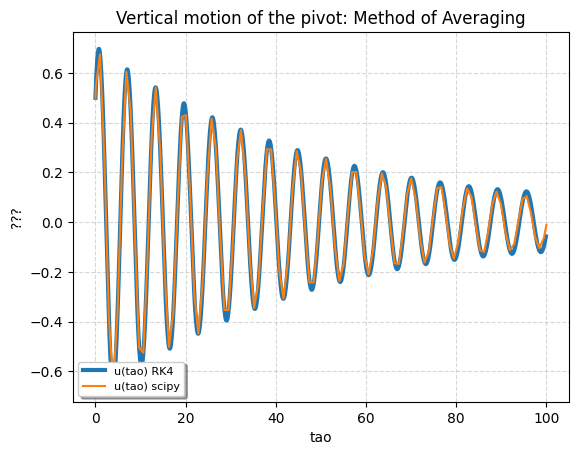

In [5]:
# PARAMETERS
initial_conditions = [0.5, 0.5] # me los saque de la nada
tao_0 = 0
tao_max = 100
delta_tao = 0.1

# SOLVE DIFFERENTIAL EQUATIONS
tao, rk4_u = rungeKuttaSolver(verticalMotion, initial_conditions, tao_0, tao_max, delta_tao) # my solution
scipy_sol = scipy.integrate.solve_ivp(verticalMotion, (tao_0, tao_max), initial_conditions) # scipy solution
scipy_u = scipy_sol.y

# PLOT AND COMPARE
plt.plot(tao, rk4_u[0], label="u(tao) RK4", linewidth=3) # u[0] refers to the 0 derivative of u, that means the u function itself
plt.plot(scipy_sol.t, scipy_u[0], label="u(tao) scipy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("tao")
plt.ylabel("???")
plt.title("Vertical motion of the pivot: Method of Averaging")
plt.legend(loc="lower left", frameon=True, shadow=True, fontsize=8)
plt.show()

**Plot for different values of** $dt$ 

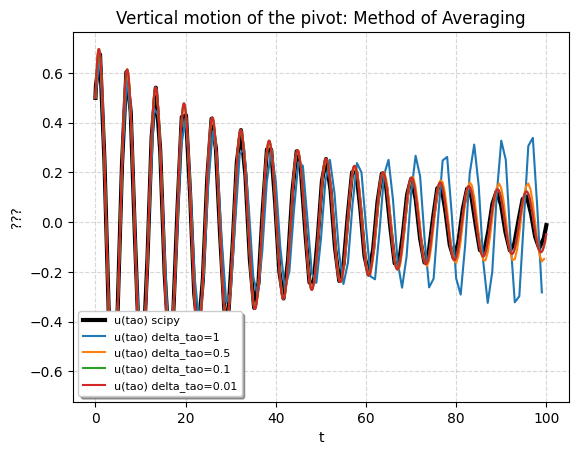

In [6]:
# PARAMETERS
initial_conditions = [0.5, 0.5] # me los saque de la nada
tao_0 = 0
tao_max = 100
delta_tao_values = [1, 0.5, 0.1, 0.01]

# SOLVE SCIPY
solution_scipy = scipy.integrate.solve_ivp(verticalMotion, (tao_0, tao_max), initial_conditions)
scipy_u = solution_scipy.y
scipy_t = solution_scipy.t
plt.plot(scipy_t, scipy_u[0], label="u(tao) scipy", linewidth=3, color="black") # PLOT SCIPY SOLUTION

# SOLVE FOR EACH dt
for delta_tao in delta_tao_values:
    t, rk4_u = rungeKuttaSolver(verticalMotion, initial_conditions, tao_0, tao_max, delta_tao)
    plt.plot(t, rk4_u[0], label=f"u(tao) delta_tao={delta_tao}") # PLOT dt SOLUTION

# PLOT OPTIONS
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("t")
plt.ylabel("???")
plt.title("Vertical motion of the pivot: Method of Averaging")
plt.legend(loc="lower left", frameon=True, shadow=True, fontsize=8)    
plt.show()